setup

In [2]:
import json, os, re, glob
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.functions import col, when, array, concat, size
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.functions import vector_to_array

In [6]:
ROOT_DIR = os.path.dirname(os.getcwd()) + "/"
ROOT_DIR

'/Users/user/juhochoi/'

In [7]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [ ]:
DATA_DIR = ROOT_DIR + "data/criteo/"
ECOSYSTEM_DIR = ROOT_DIR + "resources/ecosystem/"
CONNECTOR_DIR = ECOSYSTEM_DIR + "/spark/spark-tensorflow-connector/target"
# TRAIN_PATH = DATA_DIR + "/full/train.txt"
TRAIN_PATH = DATA_DIR + "/part/train/1000000.txt"
SCHEMA_PATH = DATA_DIR + "/full/schema.json"
CACHE_DIR = DATA_DIR + "/cache/xdeepfm"

splitting large data files. used only if necessary.

In [4]:
def split_file(file, dir, lines_per_file = 10000):
    smallfile = None
    with open(file) as bigfile:
        for lineno, line in enumerate(bigfile):
            if lineno % lines_per_file == 0:
                if smallfile:
                    smallfile.close()
                small_filename = dir + '{}.txt'.format(lineno + lines_per_file)
                smallfile = open(small_filename, "w")
            smallfile.write(line)
        if smallfile:
            smallfile.close()

In [7]:
split_file(DATA_DIR + "/full/train.txt", DATA_DIR + "/part/train/", lines_per_file = 1000000)

session

In [9]:
spark = SparkSession.builder.appName("pCTR").\
    config('spark.jars', CONNECTOR_DIR + "/spark-tensorflow-connector_2.12-1.11.0.jar").\
    getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

21/10/05 10:07:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/10/05 10:07:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


using parquet file for EDA and preprocessing

In [10]:
schema = StructType.fromJson(json.load(open(SCHEMA_PATH)))
df = spark.read.option("header", "false").option("delimiter", "\t").schema(schema).csv(TRAIN_PATH)

# EDA

## counting
count the total number of train data, and also count each label (clicked, not-clicked)

In [11]:
total = df.count()
label_count = df.groupBy("label").count().withColumn("ratio", (col("count") / total)).orderBy('label')
label_count.show()
print("total: {}".format(total))

+-----+------+--------+
|label| count|   ratio|
+-----+------+--------+
|    0|745051|0.745051|
|    1|254949|0.254949|
+-----+------+--------+

total: 1000000


missing (null) values

In [12]:
nulls = {}
for i in df.columns[1:]:
    nulls[i] = int(df.filter(col(i).isNull()).count() / total * 10000) / 100
for feature in sorted(nulls.items(), key = lambda x : x[1], reverse = True):
    print(feature, end = ', ')

('i12', 77.0), ('c22', 73.89), ('c19', 48.39), ('c20', 48.39), ('c25', 48.39), ('c26', 48.39), ('i1', 42.3), ('i10', 42.3), ('i4', 24.91), ('i13', 24.91), ('i3', 23.5), ('i6', 22.17), ('c6', 11.93), ('i7', 4.08), ('i9', 4.08), ('i11', 4.08), ('c3', 3.63), ('c4', 3.63), ('c12', 3.63), ('c16', 3.63), ('c21', 3.63), ('c24', 3.63), ('i5', 2.45), ('i8', 0.06), ('i2', 0.0), ('c1', 0.0), ('c2', 0.0), ('c5', 0.0), ('c7', 0.0), ('c8', 0.0), ('c9', 0.0), ('c10', 0.0), ('c11', 0.0), ('c13', 0.0), ('c14', 0.0), ('c15', 0.0), ('c17', 0.0), ('c18', 0.0), ('c23', 0.0), 

filter columns into three groups:
1. drop columns with high null percentage
2. convert columns around 50% null percentage to boolean
3. use columns with low null percentage (straight to preprocessing)

Although we will not clean the data yet, we can EDA based on these different sets.

In [13]:
to_drop, to_transform, to_fill = [], [], []
for feature in nulls:
    if nulls[feature] > 70:
        to_drop.append(feature)
    elif nulls[feature] > 40:
        to_transform.append(feature)
    else:
        to_fill.append(feature)
print(to_drop)
print(to_transform)
print(to_fill)

['i12', 'c22']
['i1', 'i10', 'c19', 'c20', 'c25', 'c26']
['i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i11', 'i13', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c21', 'c23', 'c24']


## Continuous Features

In [14]:
# Descriptive Statistics
to_fill_int = list(filter(lambda x : 'i' in x, to_fill))
stats = {}
described = df.select(to_fill_int).describe().collect()
for feature in to_fill_int:
    stats[feature] = {}
    stats[feature]["count"] = int(described[0][feature])
    stats[feature]["mean"] = round(float(described[1][feature]), 2)
    stats[feature]["stddev"] = round(float(described[2][feature]), 2)
    stats[feature]["min"] = int(described[3][feature])
    stats[feature]["q1"], stats[feature]["q2"], stats[feature]["q3"] = df.approxQuantile(feature, [0.25, 0.50, 0.75], 0)
    stats[feature]["max"] = int(described[4][feature])
    iqr = stats[feature]['q3'] - stats[feature]['q1']
    stats[feature]['lower'] = stats[feature]['q1'] - (iqr * 1.5)
    stats[feature]['upper'] = stats[feature]['q3'] + (iqr * 1.5)
for feature in stats.items():
    print(feature)

('i2', {'count': 1000000, 'mean': 93.97, 'stddev': 349.88, 'min': -2, 'q1': 0.0, 'q2': 2.0, 'q3': 32.0, 'max': 18522, 'lower': -48.0, 'upper': 80.0})
('i3', {'count': 764946, 'mean': 21.09, 'stddev': 344.01, 'min': 0, 'q1': 2.0, 'q2': 5.0, 'q3': 14.0, 'max': 65535, 'lower': -16.0, 'upper': 32.0})
('i4', {'count': 750884, 'mean': 6.95, 'stddev': 8.55, 'min': 0, 'q1': 2.0, 'q2': 4.0, 'q3': 9.0, 'max': 507, 'lower': -8.5, 'upper': 19.5})
('i5', {'count': 975464, 'mean': 18616.53, 'stddev': 67686.65, 'min': 0, 'q1': 829.0, 'q2': 2548.0, 'q3': 10163.0, 'max': 2527030, 'lower': -13172.0, 'upper': 24164.0})
('i6', {'count': 778260, 'mean': 116.76, 'stddev': 456.06, 'min': 0, 'q1': 8.0, 'q2': 33.0, 'q3': 102.0, 'max': 233523, 'lower': -133.0, 'upper': 243.0})
('i7', {'count': 959166, 'mean': 14.59, 'stddev': 58.28, 'min': 0, 'q1': 1.0, 'q2': 3.0, 'q3': 11.0, 'max': 8807, 'lower': -14.0, 'upper': 26.0})
('i8', {'count': 999338, 'mean': 13.38, 'stddev': 32.35, 'min': 0, 'q1': 2.0, 'q2': 8.0, 'q3

### preliminary analysis

1. we see a negative value that should be taken care of in i2. seems like an error.
2. data are all skewed (big gaps in means and medians)


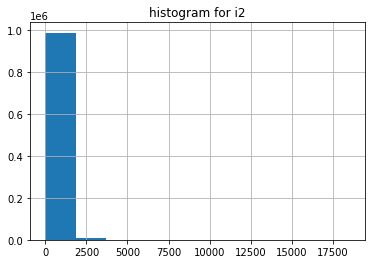

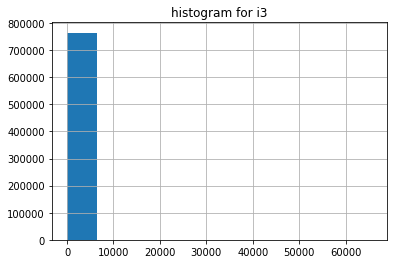

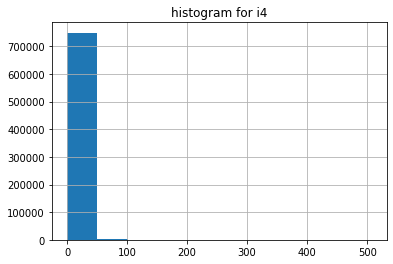

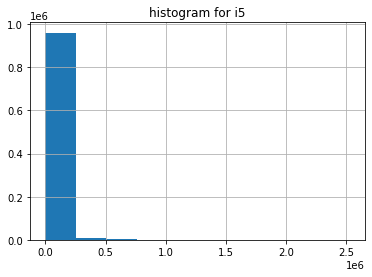

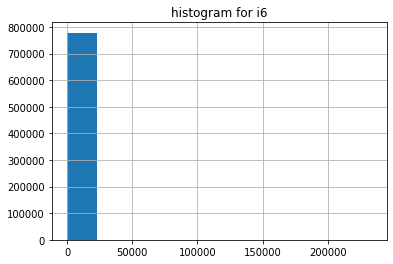

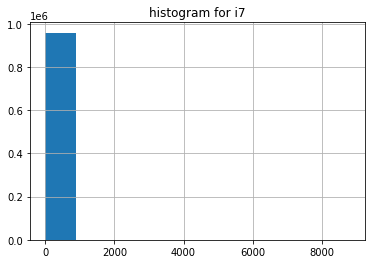

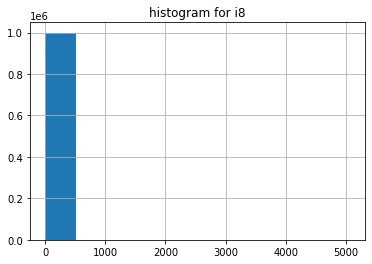

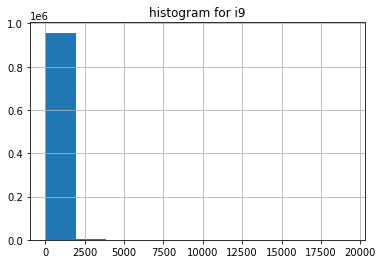

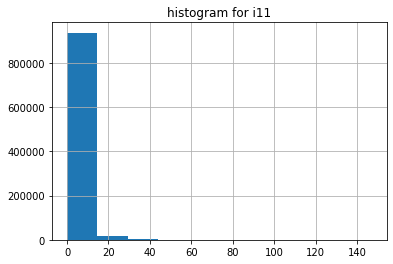

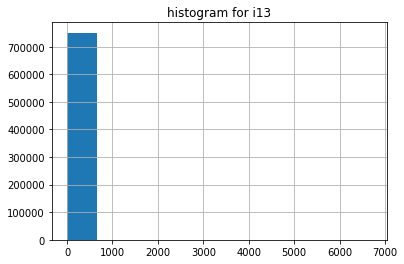

In [15]:
# # histograms
for feature in to_fill_int:
    df.select(feature).toPandas().hist()
    plt.title("histogram for {}".format(feature))
    plt.show()

histograms show that data are very skewed. this should be taken care during preprocessing.

<Figure size 1440x1296 with 0 Axes>

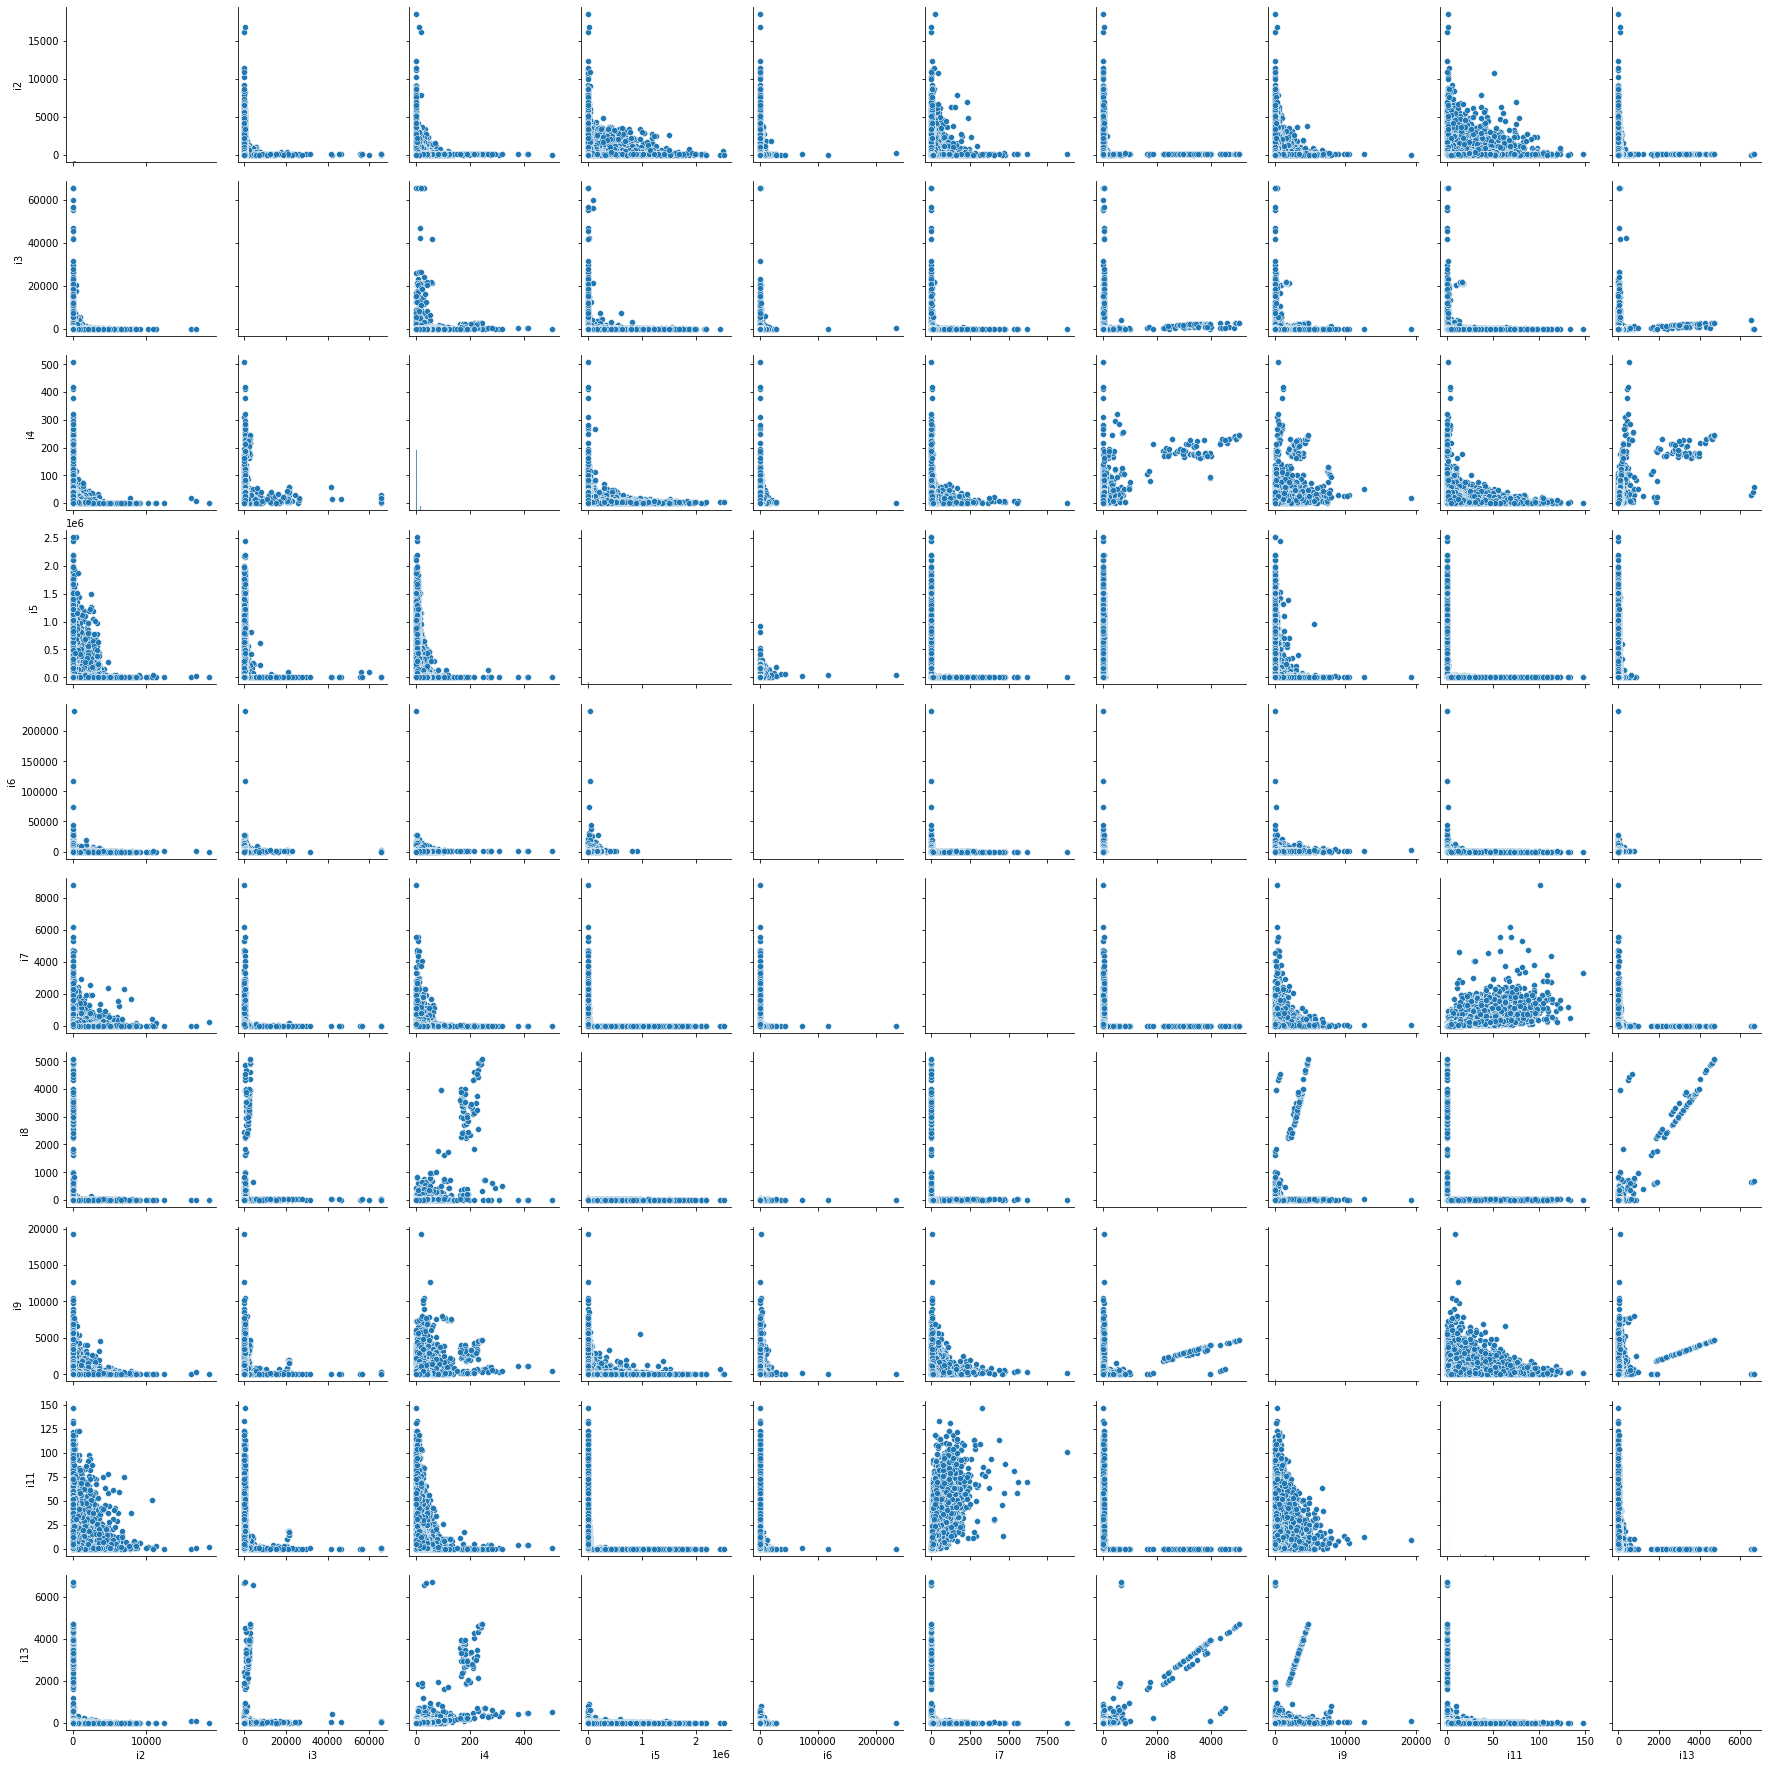

In [16]:
# pair scatter plot
plt.figure(figsize = (20, 18))
sns.pairplot(data = df.toPandas(), vars = to_fill_int) # dropna=True in default
plt.show()

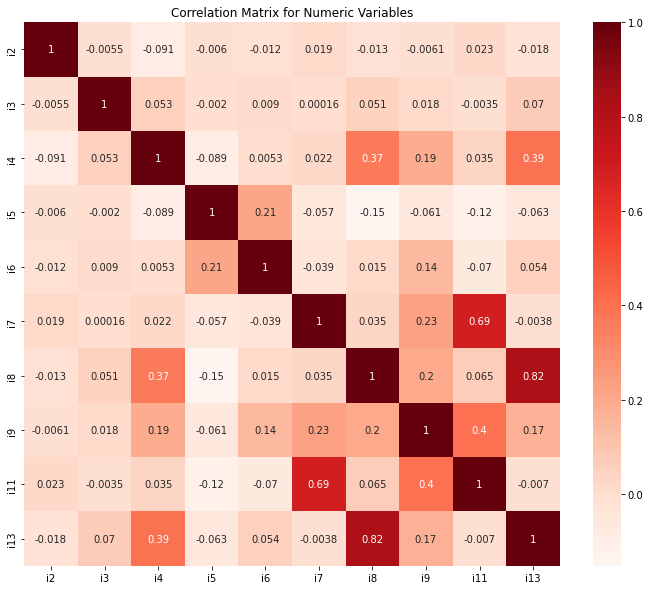

In [17]:
# Correlation Matrix
cor_matrix = df.toPandas()[to_fill_int].corr() 
plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix, annot=True, cmap = 'Reds') 
plt.title('Correlation Matrix for Numeric Variables') 
plt.show()

## Categorical Features

In [18]:
# count bar plots
to_fill_cat = list(filter(lambda x : 'c' in x, to_fill))

top 20 percentage for c1: 95.2604%


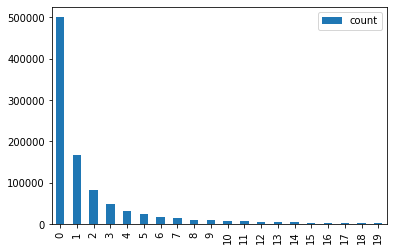

+--------+------+--------+
|      c1| count|   ratio|
+--------+------+--------+
|05db9164|500614|0.500614|
|68fd1e64|167012|0.167012|
|5a9ed9b0| 83377|0.083377|
|8cf07265| 49595|0.049595|
|be589b51| 32745|0.032745|
|5bfa8ab5| 24029|0.024029|
|87552397| 17844|0.017844|
|f473b8dc| 14126|0.014126|
|39af2607| 10986|0.010986|
|ae82ea21|  8911|0.008911|
|9a89b36c|  7803|0.007803|
|17f69355|  6388|0.006388|
|241546e0|  5423|0.005423|
|09ca0b81|  4705|0.004705|
|75ac2fe6|  4164|0.004164|
|41edac3d|  3530| 0.00353|
|439a44a4|  3427|0.003427|
|7e5c2ff4|  2919|0.002919|
|b455c6d7|  2531|0.002531|
|1464facd|  2475|0.002475|
+--------+------+--------+

top 20 percentage for c2: 56.422200000000004%


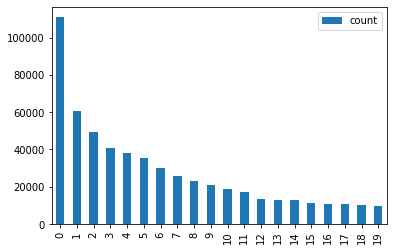

+--------+------+--------+
|      c2| count|   ratio|
+--------+------+--------+
|38a947a1|111079|0.111079|
|1cfdf714| 60554|0.060554|
|207b2d81| 49605|0.049605|
|421b43cd| 40898|0.040898|
|38d50e09| 38307|0.038307|
|287130e0| 35499|0.035499|
|4f25e98b| 30251|0.030251|
|58e67aaf| 25835|0.025835|
|04e09220| 22907|0.022907|
|09e68b86| 20888|0.020888|
|a796837e| 19068|0.019068|
|2c16a946| 17146|0.017146|
|08d6d899| 13376|0.013376|
|e112a9de| 13163|0.013163|
|95e2d337| 12700|  0.0127|
|80e26c9b| 11497|0.011497|
|78ccd99e| 10973|0.010973|
|f0cf0024| 10916|0.010916|
|d833535f| 10099|0.010099|
|ae46a29d|  9461|0.009461|
+--------+------+--------+

top 20 percentage for c3: 15.457087858206517%


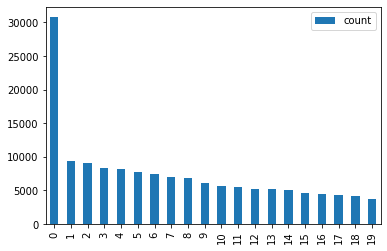

+--------+-----+--------------------+
|      c3|count|               ratio|
+--------+-----+--------------------+
|d032c263|30818|0.031980324908810726|
|b1ecc6c4| 9368|0.009721321427274283|
|02cf9876| 9018|0.009358120904265532|
|b00d1501| 8294|0.008606814679527425|
|74e1a23a| 8142|0.008449081880963622|
|77f2f2e5| 7739|0.008030882421613544|
|7da86e4b| 7472|0.007753812308346867|
|9143c832| 7021|0.007285802491555588|
|4470baf4| 6790|0.007046090146369811|
|c86b2d8d| 6168|0.006400630931194255|
|2cbec47f| 5715|0.005930545682842926|
|aa8c1539| 5573|0.005783190042079375|
|42db3232| 5200|0.005396122056130...|
|b009d929| 5161|0.005355651140709...|
|08de7b18| 5090|0.005281973320327296|
|dffca8ba| 4659|0.004834717819136517|
|d52980aa| 4435|0.004602269484410915|
|5037b88e| 4293|0.004454913843647363|
|ad4b77ff| 4222|0.004381236023265...|
|9b792af9| 3775|0.003917377069594409|
+--------+-----+--------------------+

top 20 percentage for c4: 23.999771702528395%


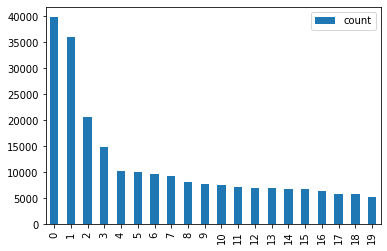

+--------+-----+--------------------+
|      c4|count|               ratio|
+--------+-----+--------------------+
|c18be181|39839| 0.04134155896041633|
|29998ed1|35934| 0.03728927883941867|
|d16679b9|20539|0.021313644405933658|
|f922efad|14814|0.015372721565290482|
|13508380|10298|0.010686397102697542|
|85dd697c|10003|0.010380270947590165|
|5dff9b29| 9545| 0.00990499712033871|
|6a14f9b9| 9211|0.009558400049810357|
|9a6888fb| 8142|0.008449081880963622|
|657dc3b9| 7766| 0.00805890074767422|
|b733e495| 7476|0.007757963171466967|
|22504558| 7066|0.007332499701656713|
|f56b7dd5| 7021|0.007285802491555588|
|e3cc371a| 6945|0.007206936092273...|
|8c8a4c47| 6833|0.007090711924910886|
|97ce69e9| 6754|0.007008732378288911|
|0fa0d423| 6291|0.006528269972137331|
|759c4a2e| 5864|0.006085165334066653|
|3e2bfbda| 5746|0.005962714872023...|
|c7043c4b| 5188|0.005383669466769747|
+--------+-----+--------------------+

top 20 percentage for c5: 99.22999999999999%


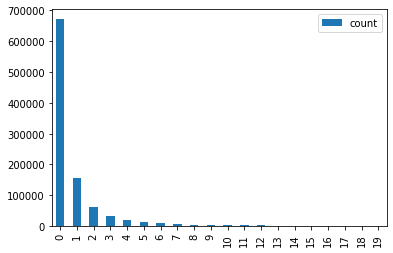

+--------+------+--------+
|      c5| count|   ratio|
+--------+------+--------+
|25c83c98|671580| 0.67158|
|4cf72387|156696|0.156696|
|43b19349| 62851|0.062851|
|384874ce| 32550| 0.03255|
|30903e74| 19216|0.019216|
|0942e0a7| 12654|0.012654|
|f281d2a7|  8625|0.008625|
|b0530c50|  5926|0.005926|
|b2241560|  4638|0.004638|
|f3474129|  3621|0.003621|
|307e775a|  2691|0.002691|
|5a3e1872|  2250| 0.00225|
|2c6b8ded|  1921|0.001921|
|89ff5705|  1579|0.001579|
|b706ee81|  1216|0.001216|
|f1d40cbe|  1133|0.001133|
|65be028e|   950|  9.5E-4|
|a9411994|   903| 9.03E-4|
|bf9f7f48|   673| 6.73E-4|
|4ea20c7d|   627| 6.27E-4|
+--------+------+--------+

top 20 percentage for c6: 100.0%


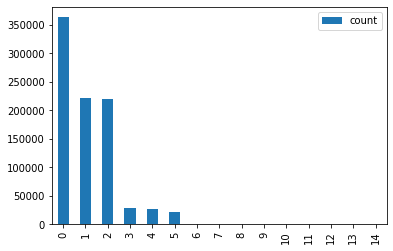

+--------+------+--------------------+
|      c6| count|               ratio|
+--------+------+--------------------+
|7e0ccccf|363531|  0.4127956886684472|
|fe6b92e5|221576| 0.25160335022982866|
|fbad5c96|219086| 0.24877591250158973|
|13718bbd| 27710|0.031465180501807744|
|6f6d9be8| 26808|0.030440944023546083|
|3bf701e7| 21529|0.024446548936247526|
|e3520422|   156|1.771406769499100...|
|c05778d5|   126|1.430751621518504...|
|c76aecf6|    57|6.472447811631329E-5|
|f1f2de2d|    46|5.223378935702476...|
|fdf16bc4|    18|2.043930887883577...|
|3c46edb2|     9|1.021965443941788...|
|3bc1ed4d|     2|2.271034319870642E-6|
|ef5a8cc6|     1|1.135517159935321E-6|
|051f8ea4|     1|1.135517159935321E-6|
+--------+------+--------------------+

top 20 percentage for c7: 12.9527%


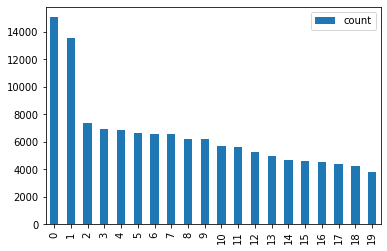

+--------+-----+--------+
|      c7|count|   ratio|
+--------+-----+--------+
|7195046d|15072|0.015072|
|dc7659bd|13554|0.013554|
|468a0854| 7330| 0.00733|
|90a2c015| 6931|0.006931|
|38eb9cf4| 6870| 0.00687|
|fe4dce68| 6643|0.006643|
|9b98e9fc| 6577|0.006577|
|d2dbdfe6| 6531|0.006531|
|81bb0302| 6207|0.006207|
|1c86e0eb| 6204|0.006204|
|ce4f7f55| 5682|0.005682|
|4aa938fc| 5612|0.005612|
|970f01b2| 5217|0.005217|
|c86e8c6b| 4972|0.004972|
|ade953a9| 4691|0.004691|
|88002ee1| 4588|0.004588|
|ad3508b1| 4507|0.004507|
|7415122a| 4354|0.004354|
|6f441cf5| 4189|0.004189|
|df5c2d18| 3796|0.003796|
+--------+-----+--------+

top 20 percentage for c8: 98.1175%


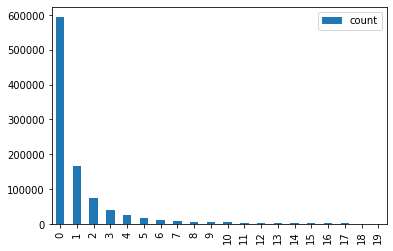

+--------+------+--------+
|      c8| count|   ratio|
+--------+------+--------+
|0b153874|594160| 0.59416|
|5b392875|166598|0.166598|
|1f89b562| 74973|0.074973|
|37e4aa92| 41581|0.041581|
|062b5529| 25930| 0.02593|
|51d76abe| 17637|0.017637|
|c8ddd494| 12538|0.012538|
|64523cfa|  9582|0.009582|
|6c41e35e|  7183|0.007183|
|985e3fcb|  5967|0.005967|
|25239412|  4668|0.004668|
|a674580f|  3932|0.003932|
|66f29b89|  3352|0.003352|
|f504a6f4|  2774|0.002774|
|a61cc0ef|  2404|0.002404|
|361384ce|  1935|0.001935|
|a25968f2|  1795|0.001795|
|0fb392dd|  1636|0.001636|
|45f7c2dd|  1287|0.001287|
|233428af|  1243|0.001243|
+--------+------+--------+

top 20 percentage for c9: 100.0%


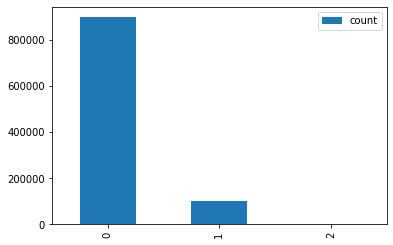

+--------+------+--------+
|      c9| count|   ratio|
+--------+------+--------+
|a73ee510|898060| 0.89806|
|7cc72ec2|101765|0.101765|
|a18233ea|   175| 1.75E-4|
+--------+------+--------+

top 20 percentage for c10: 31.3518%


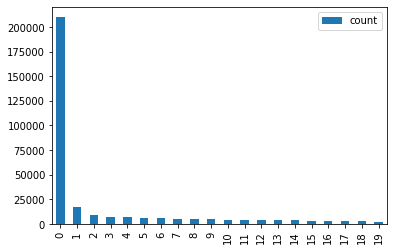

+--------+------+--------+
|     c10| count|   ratio|
+--------+------+--------+
|3b08e48b|210107|0.210107|
|efea433b| 17615|0.017615|
|fbbf2c95|  9651|0.009651|
|03e48276|  7122|0.007122|
|fa7d0797|  7086|0.007086|
|31990058|  6019|0.006019|
|5ba575e7|  5840| 0.00584|
|451bd4e4|  4822|0.004822|
|49d1ad89|  4818|0.004818|
|5162b19c|  4808|0.004808|
|f6f942d1|  4415|0.004415|
|015ac893|  4047|0.004047|
|299aecf1|  3980| 0.00398|
|f9065d00|  3973|0.003973|
|6c47047a|  3838|0.003838|
|711ec2bc|  3576|0.003576|
|acccca1c|  3350| 0.00335|
|547c0ffe|  3228|0.003228|
|4072f40f|  2690| 0.00269|
|305a0646|  2533|0.002533|
+--------+------+--------+

top 20 percentage for c11: 19.8692%


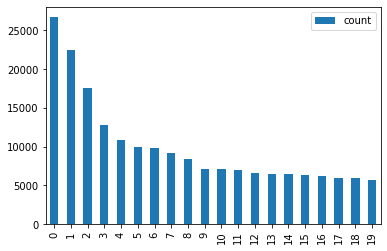

+--------+-----+--------+
|     c11|count|   ratio|
+--------+-----+--------+
|e51ddf94|26708|0.026708|
|4d8549da|22468|0.022468|
|7f8ffe57|17552|0.017552|
|1054ae5c|12795|0.012795|
|a7b606c4|10871|0.010871|
|755e4a50| 9883|0.009883|
|7e40f08a| 9852|0.009852|
|b7094596| 9200|  0.0092|
|c1ee56d0| 8397|0.008397|
|ad757a5a| 7152|0.007152|
|0f736a0c| 7148|0.007148|
|371dae82| 7002|0.007002|
|434d6c13| 6560| 0.00656|
|5874c9c9| 6510| 0.00651|
|29e4ad33| 6432|0.006432|
|68357db6| 6357|0.006357|
|a60de4e5| 6222|0.006222|
|8b94178b| 5971|0.005971|
|38f692a7| 5921|0.005921|
|17586bd8| 5691|0.005691|
+--------+-----+--------+



top 20 percentage for c12: 18.794278035188942%


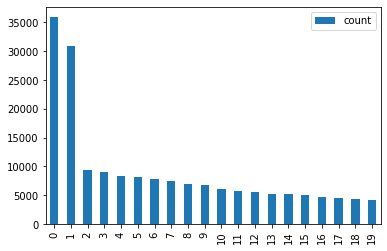

+--------+-----+--------------------+
|     c12|count|               ratio|
+--------+-----+--------------------+
|6aaba33c|35934| 0.03728927883941867|
|dfbb09fb|30818|0.031980324908810726|
|2436ff75| 9368|0.009721321427274283|
|8fe001f4| 9018|0.009358120904265532|
|e0d76380| 8294|0.008606814679527425|
|fb8fab62| 8142|0.008449081880963622|
|9f32b866| 7739|0.008030882421613544|
|ed397d6b| 7472|0.007753812308346867|
|ae1bb660| 7021|0.007285802491555588|
|bb669e25| 6790|0.007046090146369811|
|1ca7a526| 6168|0.006400630931194255|
|21a23bfe| 5715|0.005930545682842926|
|d8c29807| 5573|0.005783190042079375|
|c9669737| 5200|0.005396122056130...|
|3563ab62| 5161|0.005355651140709...|
|c5011072| 5090|0.005281973320327296|
|93bab460| 4659|0.004834717819136517|
|b519c595| 4435|0.004602269484410915|
|680d7261| 4293|0.004454913843647363|
|a2f4e8b5| 4222|0.004381236023265...|
+--------+-----+--------------------+



top 20 percentage for c13: 23.2694%


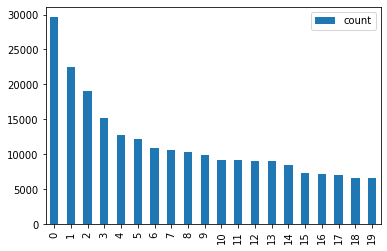

+--------+-----+--------+
|     c13|count|   ratio|
+--------+-----+--------+
|3516f6e6|29656|0.029656|
|51b97b8f|22468|0.022468|
|46f42a63|19030| 0.01903|
|1aa94af3|15225|0.015225|
|d7ce3abd|12795|0.012795|
|80467802|12171|0.012171|
|eae197fd|10897|0.010897|
|740c210d|10660| 0.01066|
|6e5da64f|10270| 0.01027|
|5978055e| 9883|0.009883|
|1f9d2c38| 9200|  0.0092|
|779f824b| 9168|0.009168|
|ebd756bd| 9035|0.009035|
|3af886ff| 9026|0.009026|
|025225f2| 8522|0.008522|
|605bbc24| 7331|0.007331|
|93b18cb5| 7152|0.007152|
|18fc2b1e| 7002|0.007002|
|768f6658| 6643|0.006643|
|7301027a| 6560| 0.00656|
+--------+-----+--------+

top 20 percentage for c14: 99.85549999999999%


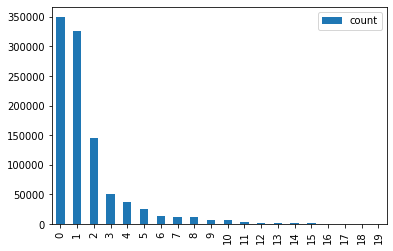

+--------+------+--------+
|     c14| count|   ratio|
+--------+------+--------+
|b28479f6|349763|0.349763|
|07d13a8f|325458|0.325458|
|1adce6ef|145087|0.145087|
|64c94865| 50376|0.050376|
|cfef1c29| 36971|0.036971|
|051219e6| 25255|0.025255|
|8ceecbc8| 14113|0.014113|
|f862f261| 12433|0.012433|
|d2dfe871| 12387|0.012387|
|ad1cc976|  6874|0.006874|
|32813e21|  6006|0.006006|
|f7c1b33f|  3552|0.003552|
|0601d3b5|  2523|0.002523|
|dcd762ee|  1696|0.001696|
|243a4e68|  1691|0.001691|
|687dfaf4|  1619|0.001619|
|ec19f520|   831| 8.31E-4|
|91233270|   770|  7.7E-4|
|26ac7cf4|   650|  6.5E-4|
|ab7390e9|   500|  5.0E-4|
+--------+------+--------+



top 20 percentage for c15: 19.4184%


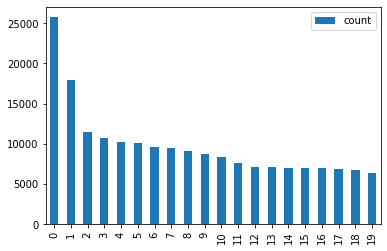

+--------+-----+--------+
|     c15|count|   ratio|
+--------+-----+--------+
|2d0bb053|25774|0.025774|
|d345b1a0|17990| 0.01799|
|e1ac77f7|11407|0.011407|
|f3002fbd|10756|0.010756|
|0c67c4ca|10155|0.010155|
|10935a85|10122|0.010122|
|3628a186| 9598|0.009598|
|3c767806| 9445|0.009445|
|10040656| 9128|0.009128|
|69f825dd| 8742|0.008742|
|a9d1ba1a| 8356|0.008356|
|af56328b| 7623|0.007623|
|f775a6d5| 7153|0.007153|
|9efd8b77| 7046|0.007046|
|42b3012c| 7036|0.007036|
|310d155b| 6992|0.006992|
|dfab705f| 6962|0.006962|
|f0bf9094| 6843|0.006843|
|06373944| 6701|0.006701|
|8ab5b746| 6355|0.006355|
+--------+-----+--------+

top 20 percentage for c16: 20.25641956924418%


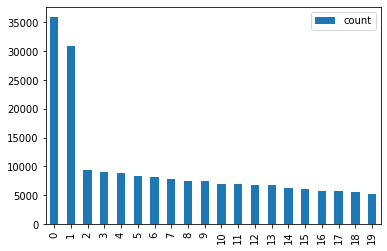

+--------+-----+--------------------+
|     c16|count|               ratio|
+--------+-----+--------------------+
|b041b04a|35934| 0.03728927883941867|
|84898b2a|30819| 0.03198136262459075|
|f4ead43c| 9368|0.009721321427274283|
|36103458| 9018|0.009358120904265532|
|f8b34416| 8906| 0.00924189673690273|
|1203a270| 8294|0.008606814679527425|
|c6b1e1b2| 8142|0.008449081880963622|
|31ca40b6| 7824| 0.00811908826291567|
|056d8866| 7472|0.007753812308346867|
|01adbab4| 7431|0.007711265961365841|
|bad5ee18| 7021|0.007285802491555588|
|c4de5bba| 6918|0.007178917766213012|
|2b2ce127| 6790|0.007046090146369811|
|5a9431f3| 6731|0.006984864915348336|
|6bb29970| 6267|0.006503364793416731|
|ba46c3a1| 6168|0.006400630931194255|
|587267a3| 5715|0.005930545682842926|
|776f5665| 5650|0.005863094157141301|
|c64d548f| 5573|0.005783190042079375|
|b688c8cc| 5161|0.005355651140709...|
+--------+-----+--------------------+

top 20 percentage for c17: 100.0%


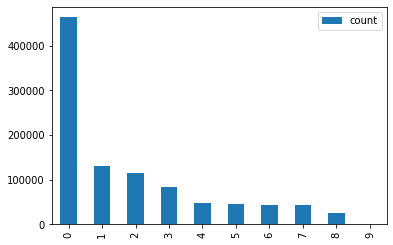

+--------+------+--------+
|     c17| count|   ratio|
+--------+------+--------+
|e5ba7672|463179|0.463179|
|07c540c4|131285|0.131285|
|d4bb7bd8|114675|0.114675|
|3486227d| 84511|0.084511|
|776ce399| 48298|0.048298|
|27c07bd6| 46647|0.046647|
|8efede7f| 44166|0.044166|
|1e88c74f| 42665|0.042665|
|2005abd1| 24536|0.024536|
|af5d780c|    38|  3.8E-5|
+--------+------+--------+



top 20 percentage for c18: 33.1941%


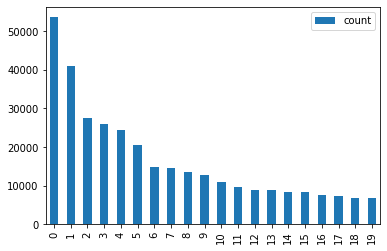

+--------+-----+--------+
|     c18|count|   ratio|
+--------+-----+--------+
|e88ffc9d|53723|0.053723|
|2804effd|40898|0.040898|
|891589e7|27541|0.027541|
|c21c3e4c|25835|0.025835|
|395856b0|24421|0.024421|
|7ef5affa|20378|0.020378|
|5aed7436|14905|0.014905|
|6fc84bfb|14533|0.014533|
|582152eb|13521|0.013521|
|fffe2a63|12772|0.012772|
|e7e991cb|10973|0.010973|
|e4ca448c| 9598|0.009598|
|38dce391| 8953|0.008953|
|13145934| 8725|0.008725|
|e161d23a| 8374|0.008374|
|5bb2ec8e| 8340| 0.00834|
|bd17c3da| 7562|0.007562|
|7b06fafe| 7372|0.007372|
|1cdbd1c5| 6843|0.006843|
|3cb7e3f0| 6674|0.006674|
+--------+-----+--------+



top 20 percentage for c21: 19.621026197134867%


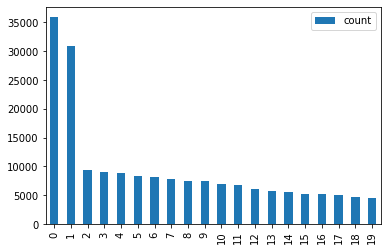

+--------+-----+--------------------+
|     c21|count|               ratio|
+--------+-----+--------------------+
|723b4dfd|35934| 0.03728927883941867|
|0014c32a|30818|0.031980324908810726|
|4f1aa25f| 9368|0.009721321427274283|
|e587c466| 9018|0.009358120904265532|
|f3ddd519| 8906| 0.00924189673690273|
|73d06dde| 8294|0.008606814679527425|
|99c09e97| 8142|0.008449081880963622|
|dfcfc3fa| 7739|0.008030882421613544|
|deaf6b52| 7472|0.007753812308346867|
|21c9516a| 7431|0.007711265961365841|
|0429f84b| 7021|0.007285802491555588|
|2b796e4a| 6790|0.007046090146369811|
|eb0fc6f8| 6168|0.006400630931194255|
|c2a93b37| 5715|0.005930545682842926|
|5f957280| 5573|0.005783190042079375|
|288eaded| 5200|0.005396122056130...|
|2754aaf1| 5161|0.005355651140709...|
|e754c5e1| 5090|0.005281973320327296|
|d9d9202f| 4659|0.004834717819136517|
|1fe472e2| 4580|0.004752738272514541|
+--------+-----+--------------------+

top 20 percentage for c23: 100.0%


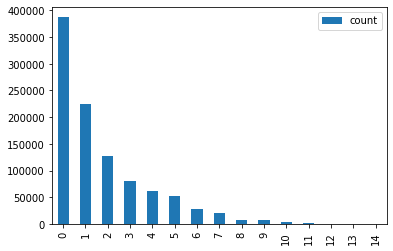

+--------+------+--------+
|     c23| count|   ratio|
+--------+------+--------+
|32c7478e|387566|0.387566|
|3a171ecb|224581|0.224581|
|423fab69|126903|0.126903|
|bcdee96c| 80333|0.080333|
|c7dc6720| 60954|0.060954|
|be7c41b4| 51951|0.051951|
|55dd3565| 27396|0.027396|
|dbb486d7| 20161|0.020161|
|93bad2c0|  7500|  0.0075|
|c3dc6cef|  6874|0.006874|
|85d5a995|  4269|0.004269|
|b264a060|  1176|0.001176|
|25e3c76b|   233| 2.33E-4|
|72592995|    96|  9.6E-5|
|003cc7f4|     7|  7.0E-6|
+--------+------+--------+



top 20 percentage for c24: 39.62009225293284%


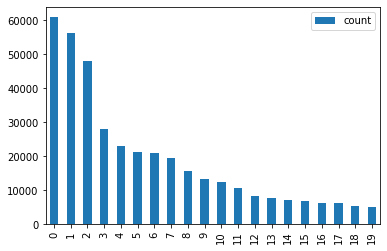

+--------+-----+--------------------+
|     c24|count|               ratio|
+--------+-----+--------------------+
|b34f3128|60878| 0.06317406125636249|
|3fdb382b|56306|0.058429624710088154|
|3b183c5c|47840| 0.04964432291639643|
|1793a828|28004| 0.02906019270382035|
|ded4aac9|22876|0.023738786183852105|
|aee52b6f|21258| 0.02205976205177164|
|8fc66e78|20884|0.021671656350042288|
|9117a34a|19534|0.020270740047008524|
|df487a73|15704| 0.01629628860951274|
|d9556584|13168|0.013664641391369317|
|45ab94c8|12456|0.012925787755991512|
|8f079aa5|10533| 0.01093026031100342|
|335a6a1e| 8251| 0.00856219290098635|
|6c1cdd05| 7672| 0.00796135546435187|
|c0d61a5c| 7022|0.007286840207335613|
|8d365d3b| 6833|0.007090711924910886|
|590b856f| 6137| 0.00636846174201348|
|e5fca70a| 6127| 0.00635808458421323|
|8d653a3e| 5374|0.005576684601854398|
|89bd83a1| 4944|0.005130466816443645|
+--------+-----+--------------------+



In [19]:
for feature in to_fill_cat:
    x = df.filter(df[feature].isNotNull())
    n = x.count()
    top_cnt = 20
    top = x.groupBy(feature).count().orderBy("count", ascending=False).limit(top_cnt)
    print("top {} percentage for {}: {}%".format(\
        top_cnt, feature, top.groupBy().sum().collect()[0][0] / n * 100))
    top.toPandas().plot.bar()
    plt.show()
    top = top.withColumn("ratio", (col("count") / n))
    top.show()

some categorical features have high number of unique categories.
distribution of counts are mostly skewed.
we should bucketize them by frequency.

# Data Cleaning

balance the data.
Note that determining null values is prior to balancing.

In [20]:
ratio = label_count.collect()[1]['ratio'] / label_count.collect()[0]['ratio']
clicked = df.filter(col("label") == 1)
unclicked = df.filter(col("label") == 0).sample(False, ratio)
df = clicked.union(unclicked)

clean up after balance.

In [21]:
# drop
df = df.drop(*to_drop) # * : for each

In [22]:
# transform to boolean
for feature in to_transform:
    df = df.withColumn(feature, when(df[feature].isNull(), 0).otherwise(1).cast('string'))

## Continous Feature Preprocessing

In [23]:
for feature in to_fill_int:
    st = stats[feature]
    # fill nulls with median (high outliers, so mean will be skewed) and ceil any negative values
    df = df.withColumn(feature, when(col(feature).isNull(), st['q2']).when(col(feature) < 0, 0).otherwise(col(feature)))
    # replace outliers with median (again, mean is skewed)
    df = df.withColumn(feature, when((col(feature) > st['upper']) | (col(feature) < st['lower']), st['q2']).otherwise(col(feature)))
    # standardize (z-scoring)
    df = df.withColumn(feature, (col(feature) - st['mean']) / st['stddev'])

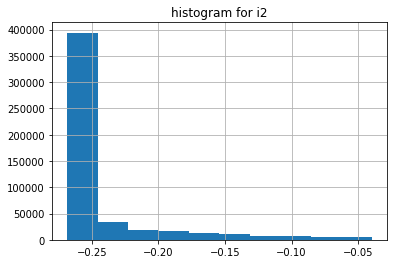

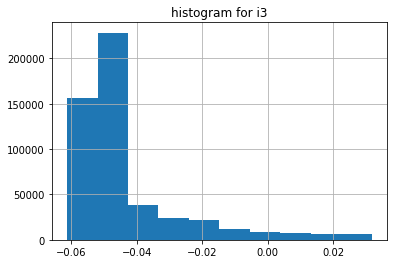

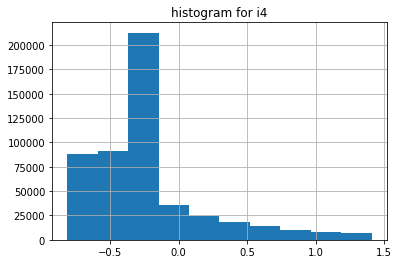

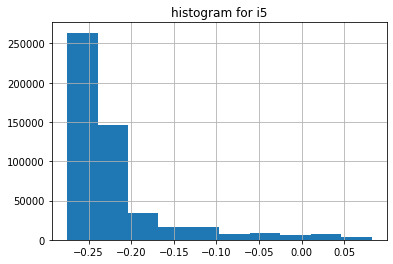

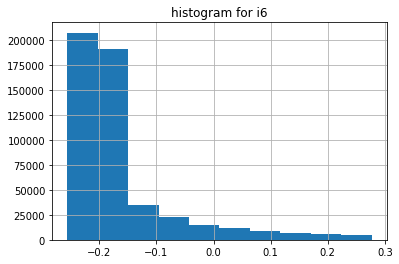

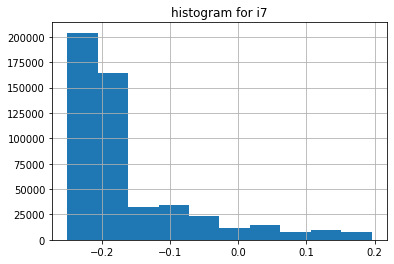

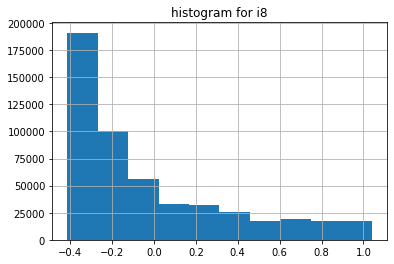

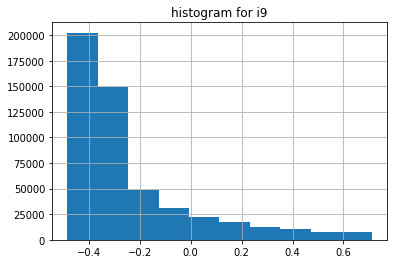

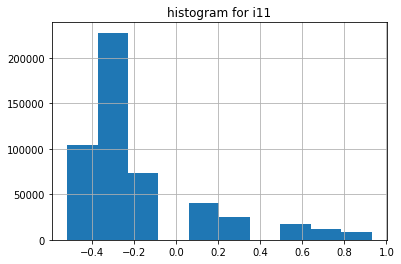

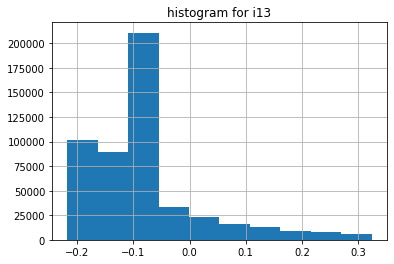

In [24]:
# standardized visualization
for feature in to_fill_int:
    df.select(feature).toPandas().hist()
    plt.title("histogram for {}".format(feature))
    plt.show()

analysis

1. i11 can be changed as categorical.
2. i2, i5can be changed as binary (polar data)
3. i4, i13 show randomness, but for other not mentioned, they all have an exponentiality except at the start

## Categorical Feature Preprocessing

In [25]:
# fill nulls with mode for categorical features
label = df["label"]
clicked = df.filter(label == 1)
unclicked = df.filter(label == 0)
for feature in to_fill_cat:
    col = df[feature]
    clicked_mode = clicked.filter(col.isNotNull()).groupBy(feature).count().orderBy("count", ascending=False).first()[0]
    unclicked_mode = unclicked.filter(col.isNotNull()).groupBy(feature).count().orderBy("count", ascending=False).first()[0]
    df = df.withColumn(feature, when(col.isNull() & (label == 1), clicked_mode).\
        when(col.isNull() & (label == 0), unclicked_mode).otherwise(col))

In [ ]:
labels = df.select("label")
features = df.drop("label")
numeric_columns, categorical_columns = [], []
for field in features.schema.fields:
    if str(field.dataType) in ('IntegerType', 'DoubleType'):
        numeric_columns.append(field.name)
    elif str(field.dataType) in ('StringType'):
        categorical_columns.append(field.name)

In [ ]:
numeric_columns = natural_sort(numeric_columns)
categorical_columns = natural_sort(categorical_columns)

In [ ]:
print("encoding categorical feature columns...")
original_cols = categorical_columns
indexed_cols = [s + "_indexed" for s in categorical_columns]
stringIndexer = StringIndexer(inputCols = original_cols, outputCols = indexed_cols)
features = stringIndexer.fit(features).transform(features)
# one-hot encoding features
encoded_cols = [s + "_vec" for s in categorical_columns]
ohe = OneHotEncoder(inputCols = indexed_cols, outputCols = encoded_cols, dropLast = False)
features = ohe.fit(features).transform(features)
features = features.drop(*original_cols).drop(*indexed_cols)

encoding categorical feature columns...


In [ ]:
cardinalities = dict(zip(numeric_columns, [1] * len(numeric_columns)))
for feature, encoded in zip(original_cols, encoded_cols):
    features = features.withColumnRenamed(encoded, feature).withColumn(feature, vector_to_array(feature))
    cardinalities[feature] = features.select(size(feature).alias("n")).collect()[0]['n']

In [ ]:
# concatenating cateogircal columns and creating dense numeric column
features = features.select([
    array(numeric_columns).alias('numeric'), 
    concat(*categorical_columns).alias('categorical')])

In [ ]:
features = features.select(concat(*['numeric', 'categorical']))
# features.show(1)

In [6]:
k = 10
if not os.path.isdir(CACHE_DIR):
    os.makedirs(CACHE_DIR)

In [ ]:
cardinality_file = open(CACHE_DIR + "/info.json", "w+")
cardinality_file.write(json.dumps(cardinalities)) 
cardinality_file.close()

In [ ]:
print("splitting data to {} folds...".format(k))
weights = [1 / k] * k
for i, fold in enumerate(features.randomSplit(weights)): 
    path = CACHE_DIR + "/features{}.tfrecord".format(i + 1)
    fold.write.format("tfrecords").option("recordType", "Example").save(path)
for i, fold in enumerate(labels.randomSplit(weights)): 
    path = CACHE_DIR + "/labels{}.tfrecord".format(i + 1)
    fold.write.format("tfrecords").option("recordType", "Example").save(path)

splitting data to 10 folds...


In [25]:
metadata = json.load(open(CACHE_DIR + "/metadata.json"))
print("loading train data...")
feature_files = [glob.glob(CACHE_DIR + "/features{}.tfrecord/part*".format(i + 1)) for i in range(k)]
label_files = [glob.glob(CACHE_DIR + "/labels{}.tfrecord/part*".format(i + 1)) for i in range(k)]
feature_records = [tf.data.TFRecordDataset(filenames = feature_files[i]) for i in range(k)]
label_records = [tf.data.TFRecordDataset(filenames = label_files[i]) for i in range(k)]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/user/juhochoi/data/criteo/cache/xdeepfm/metadata.json'

In [ ]:
# Create a description of the features.
sparse_size = metadata["num_features"]
feature_description = {'sparse_feature' : tf.io.FixedLenFeature(shape = (sparse_size), dtype = tf.float32)}

In [ ]:
# parsing each fold into a dataset
def map_func(element):
    # Parse the input `tf.train.Example` proto using the dictionary above.
    return tf.io.parse_example(element, feature_description)
feature_datasets = [record.map(map_func) for record in feature_records]
label_datasets = [record.map(map_func) for record in label_records]

In [ ]:
for dataset in feature_datasets:
    

In [ ]:

        # numeric_inputs, categorical_inputs = tf.split(
        #     inputs, [len(self.numeric_fields), self.num_features - len(self.categorical_fields)], axis = 1)
        # # directly apply embedding vectors to dense (numeric) features
        # numeric_embedded = 
        # # split each sparse vector into each field, and apply embedding.
        # categorical_inputs = tf.split(categorical_inputs, list(self.cardinalities.values()), axis = 1)
        # categorical_embedded = []
        # for sparse_input, embedding in zip(categorical_inputs, self.categorical_embeddings):
        #     categorical_embedded.append(tf.tensordot(sparse_input, embedding, axes = (-1, 0)))
        # categorical_embedded = tf.concat(categorical_embedded, -1)